In [1]:
## For data handling
import pandas as pd
import numpy as np

## For plotting
import matplotlib.pyplot as plt
import seaborn as sns

## This sets the plot style
## to have a grid on a white background
sns.set_style("whitegrid")

# Categorical Data In `sklearn` Tree Based Algorithms

The notes in this notebook are adapted from this blog post <a href="https://roamanalytics.com/2016/10/28/are-categorical-variables-getting-lost-in-your-random-forests/">https://roamanalytics.com/2016/10/28/are-categorical-variables-getting-lost-in-your-random-forests/</a>.

Before moving on to the next algorithm we're going to take a quick aside and discuss a shortcoming in `sklearn`'s tree based algorithms. Check out the following screenshot from the `sklearn` docs page
<img src="sklearn_tree_int.png"></img>

So what's the problem here? `DecisionTreeClassifier.fit(X,y)` takes our features, $X$, and casts them as floats which are decimals. This is fine for continuous predictors, binary predictors and probably ordinals. But, what about true categorical variables? Probably not for the best.

However, we should be okay right? We have one-hot encoding! Even this isn't ideal. Suppose you have one categorical predictor with ten categories, that's nine additional variables. What about one with $100$ variables, or more? This quickly becomes a problem with more complicated categorical variables. As we'll see below with a cooked up example.

There are two main problems with one hot encoding and tree based methods:
<ol>
    <li> 
        When you one-hot encode a variable with many categories you end up with many sparse columns. The resulting sparsity virtually ensures that continuous variables are assigned higher feature importance.
    </li>
    <li>
        A single level of a categorical variable must meet a very high bar in order to be selected for splitting early in the tree building. This can degrade predictive performance.
    </li>
</ol>

Let's examine this with our phony data.

We'll use Nick Dingwall, Chris Potts's code to generate the data but here's the idea.

Take a categorical variable, $c$, that takes values from two sets $C^+$ and $C^-$ each with $100$ unique categories, and a variable $z$ that is continuous. The target value $y$ has the following true classification rule:
$$
y = \left\lbrace \begin{array}{c c}
    1, & \text{ if } & c\in C^+ \text{ or } z > 10\\
    0, & \text{ else.}
\end{array}
\right.
$$

Just like in the real world when you collect the data you don't know this real classification rule, so you collect $10,000$ samples with $y$, $z$, and $c$ values as well as $100$ additional potential predictors (all of which are continuous for simplicity).

In [4]:
# We import Dingwall and Potts's python code to generate the data
from tree_categorical_variables import *

In [5]:
# data_categorical is the collected data set
# data_onehot is the onehot encoded version
data_categorical, data_onehot = generate_dataset(
    num_x=100, n_samples=10000, n_levels=200)

In [6]:
# Examine the data as it was collected
data_categorical.head()

,y,c,z,x0,x1,x2,x3,x4,x5,x6,...,x90,x91,x92,x93,x94,x95,x96,x97,x98,x99
0,0,Bab,4.091385,-0.218338,-6.558499,-4.877126,13.330441,-12.078606,-5.182536,-9.045180,...,-3.495792,-19.490994,-8.680265,0.269174,-2.255799,-10.791099,10.059742,-6.454061,3.159238,-0.743074
1,0,Bck,6.402658,16.275481,2.682710,0.657253,-2.077715,8.758147,14.413890,3.868668,...,5.880504,6.033147,20.527731,0.430270,-5.560019,-10.785094,-16.603483,13.859445,-7.621127,-5.550143
2,0,Bco,-0.739105,-3.631592,11.558506,-11.422741,6.337942,19.956145,5.536230,1.922554,...,2.619675,-7.302467,-1.861055,-0.928654,-17.943936,-20.129385,1.372400,5.578552,6.529250,14.097206
3,0,Bbt,8.050952,0.317058,-5.249805,-2.657634,-12.799288,7.932134,2.782439,8.943227,...,1.142909,-22.607940,0.074396,-1.799347,-2.368911,-9.859825,8.173461,8.605642,12.051160,-3.010782
4,0,Bbn,8.054297,7.869959,-4.785612,14.650067,-0.975402,1.528948,8.612125,-8.873962,...,25.698345,-6.220586,-9.660987,-9.011791,-1.493865,-16.133608,-6.323046,21.902782,0.839427,-0.116008


In [7]:
# Examine the onehot encoded data
data_onehot.head()

,y,z,x0,x1,x2,x3,x4,x5,x6,x7,...,c_Bdm,c_Bdn,c_Bdo,c_Bdp,c_Bdq,c_Bdr,c_Bds,c_Bdt,c_Bdu,c_Bdv
0,0,4.091385,-0.218338,-6.558499,-4.877126,13.330441,-12.078606,-5.182536,-9.045180,-12.521464,...,0,0,0,0,0,0,0,0,0,0
1,0,6.402658,16.275481,2.682710,0.657253,-2.077715,8.758147,14.413890,3.868668,9.294948,...,0,0,0,0,0,0,0,0,0,0
2,0,-0.739105,-3.631592,11.558506,-11.422741,6.337942,19.956145,5.536230,1.922554,-4.953004,...,0,0,0,0,0,0,0,0,0,0
3,0,8.050952,0.317058,-5.249805,-2.657634,-12.799288,7.932134,2.782439,8.943227,-2.634426,...,0,0,0,0,0,0,0,0,0,0
4,0,8.054297,7.869959,-4.785612,14.650067,-0.975402,1.528948,8.612125,-8.873962,-2.227994,...,0,0,0,0,0,0,0,0,0,0


Now build a decision tree that goes three layers deep and see what happens. Don't worry about the train test split here. Mess around with adding more layers if you'd like as well.

In [8]:
# Code Here
# Sample Solution
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

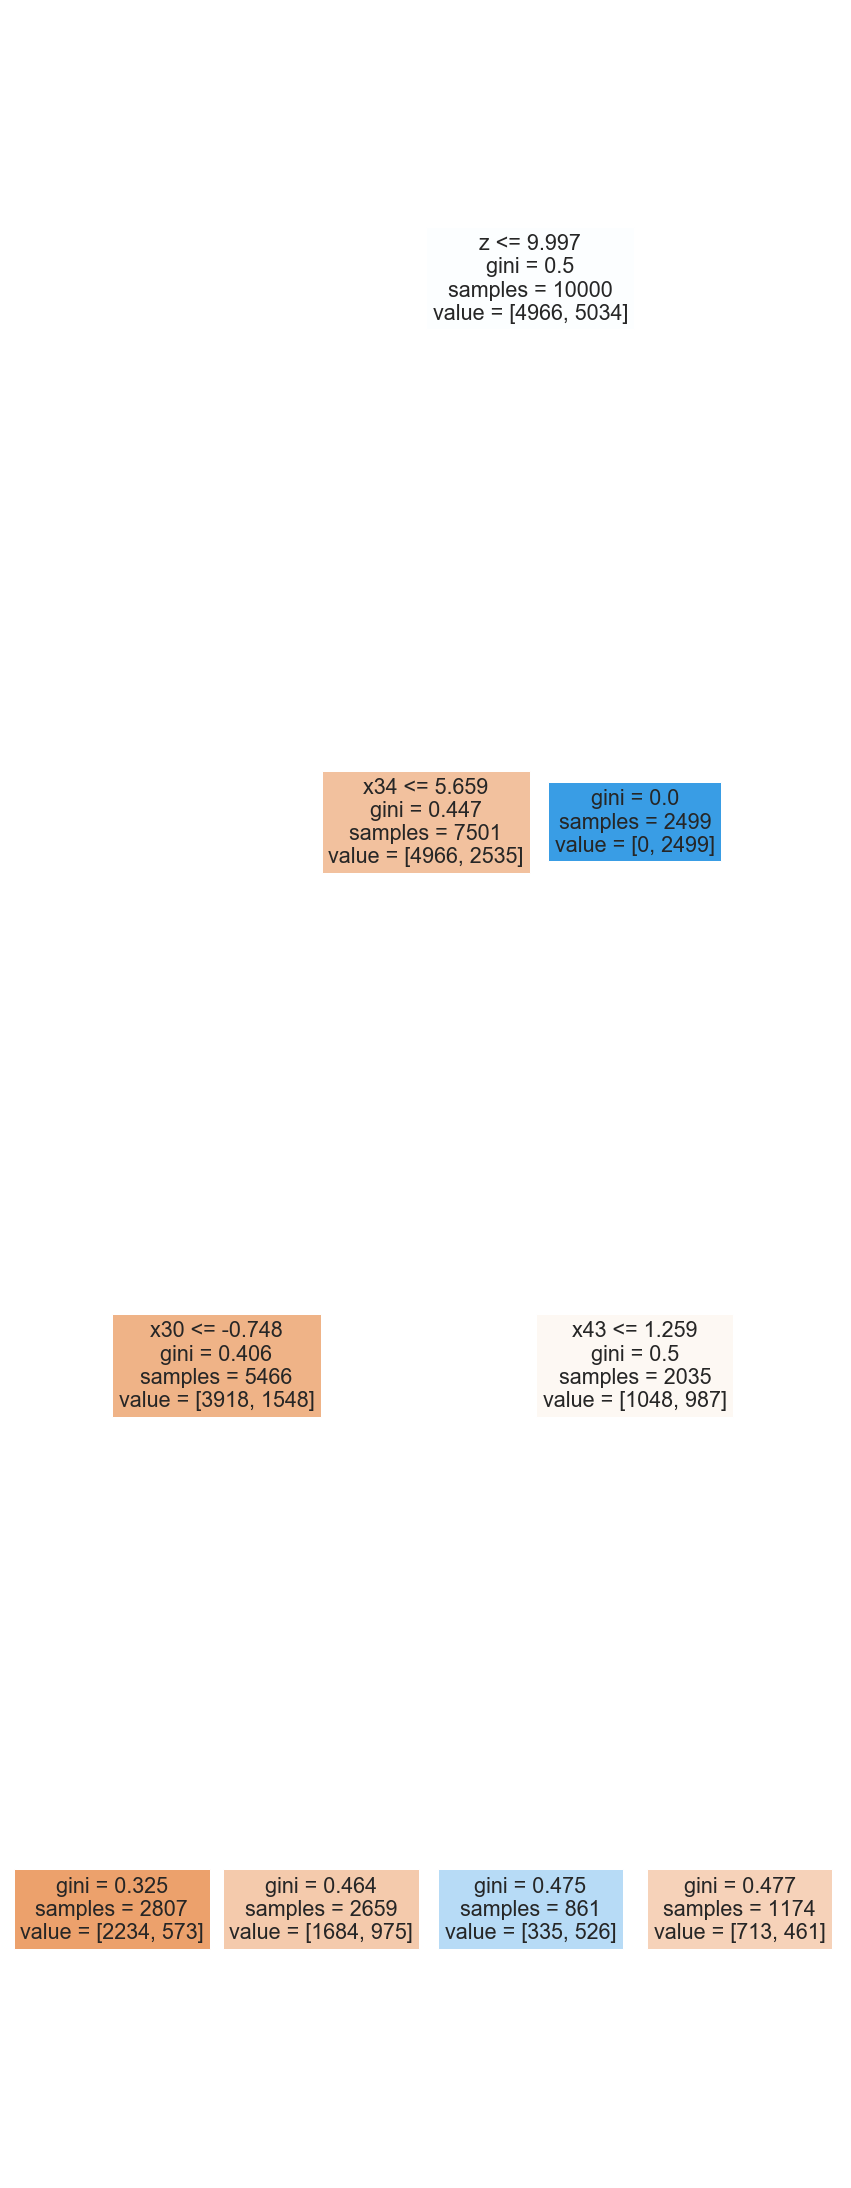

In [9]:
# Code Here
# Sample Solution
tree_clf = DecisionTreeClassifier(max_depth = 3)
tree_clf.fit(data_onehot.iloc[:,1:],data_onehot.iloc[:,0])

plt.figure(figsize = (15,40))

plot_tree(tree_clf, filled = True, feature_names = data_onehot.columns[1:])
plt.show()

### Dear Diary 

Write down what you observed here. Is the decision tree able to identify the importance of the categorical variable?









Now play around with `sklearn`'s random forest classifier. Build a classifier and then look at the feature importance of the variables. What do you see?

In [10]:
# Code Here
# Sample Solution
from sklearn.ensemble import RandomForestClassifier

In [11]:
# Code Here
# Sample Solution
forest_clf = RandomForestClassifier(n_estimators = 100, max_depth = 3)
forest_clf.fit(data_onehot.iloc[:,1:],data_onehot.iloc[:,0])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=3, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [19]:
# Code Here
# Sample Solution
names = []
scores = []
for name, score in zip(data_onehot.columns[1:],forest_clf.feature_importances_):
    names.append(name)
    scores.append(np.round(score,4))
    
score_df = pd.DataFrame({'feature':names,'importance_score':scores})

score_df.sort_values('importance_score',ascending=False).reset_index(drop=True).head(50)

,feature,importance_score
0,z,0.2555
1,x34,0.0708
2,x32,0.0639
3,x98,0.0511
4,x30,0.0503
5,x8,0.0416
6,x74,0.0384
7,x6,0.0302
8,x94,0.0297
9,x15,0.0292


### Dear Diary 2

Write down what you observed about the random forest classifier here










## What to Do?

So we can see that `sklearn`'s tree based methods can struggle with categorical variables. And let's point out that the phony data set we created isn't too unrealistic. Imagine you're trying to predict how a state will vote in an upcoming election. Let's say you're trying to predict if a county will vote Democrat. $c$ could be the state the county is in. We could take $C^+$ to be the states that have historically voted Democrat and $C^-$ those that either flip or historically vote Republican. Say $z$ is the latest polling data.

It's not unreasonable that you may encounter problems like this in your career as a data scientist. There are a couple of approaches you could take to address this shortcoming.
<ul>
   <li> If you're not in a production environment, like a personal project or research project, you may want to try R. R considers all categories of $c$ at once in its `rpart` package. However, R's `randomForest` package may have limitations on the number of unique categories $c$ has.</li>
   <li> There are python packages that address this shortcoming. One example is <a href = "http://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/intro.html">h2o</a>, but this package requires a bit more technical work than we'll go into during this course. However, you are encouraged to explore it on your own.</li>
</ul>

The important take away is that you should be careful using `sklearn` building decision trees on data with high cardinality categorical variables.